# Parcial: Construcción e implementación de , Random Forest 

En este parcial podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de  Random Forest. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este parcial se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#librerias
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [3]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [4]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [5]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 0 - exploracion y analisis de datos 
Los estudiantes deben analizar cuidadosamente los datos del conjunto dataTrain_carListings, identificando posibles valores nulos o inconsistencias. En caso de encontrar datos faltantes, deberán aplicar técnicas de imputación adecuadas para completar la información de manera coherente. Posteriormente, se espera que realicen una exploración visual mediante gráficos que permitan comprender la distribución y las relaciones entre las variables principales.

--- 🔍 Revisión inicial del dataset ---

 Valores nulos por columna:

Price          0
Year           0
Mileage        0
M_Camry        0
M_Camry4dr     0
M_CamryBase    0
M_CamryL       0
M_CamryLE      0
M_CamrySE      0
M_CamryXLE     0
dtype: int64

 Estadísticas descriptivas generales:

              Price          Year        Mileage
count  10495.000000  10495.000000   10495.000000
mean   14538.403716   2013.553883   52509.430395
std     3922.420961      3.116585   36791.736601
min     5002.000000   1998.000000       5.000000
25%    11999.000000   2012.000000   26461.000000
50%    15000.000000   2014.000000   41680.000000
75%    16999.000000   2016.000000   71355.500000
max    32444.000000   2018.000000  232658.000000


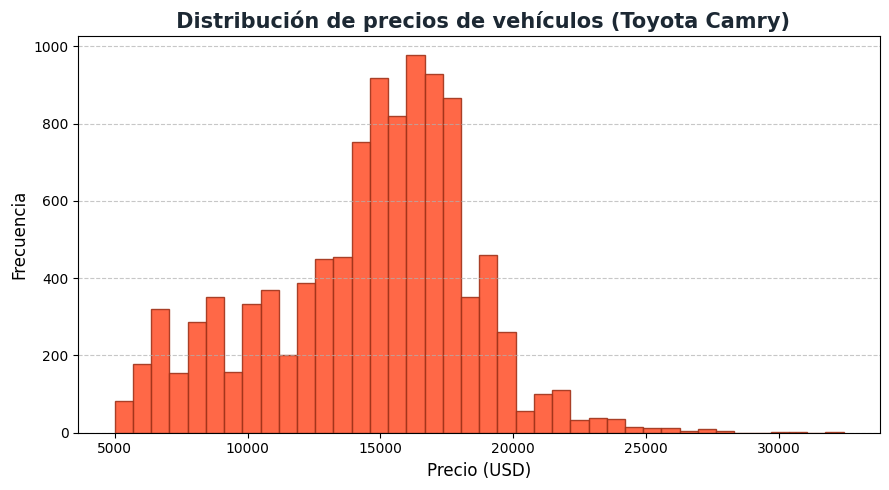

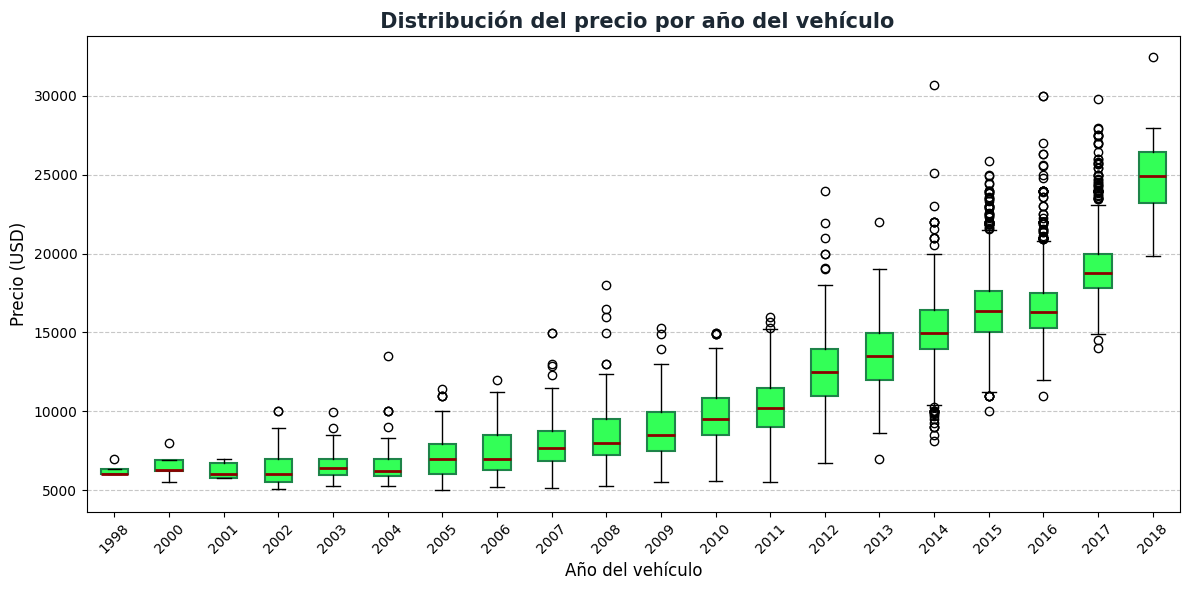

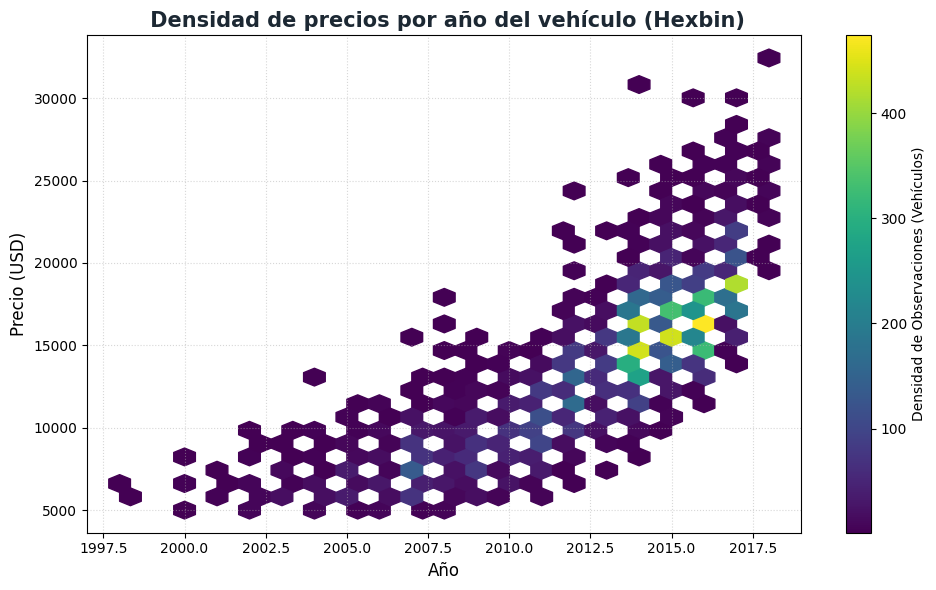

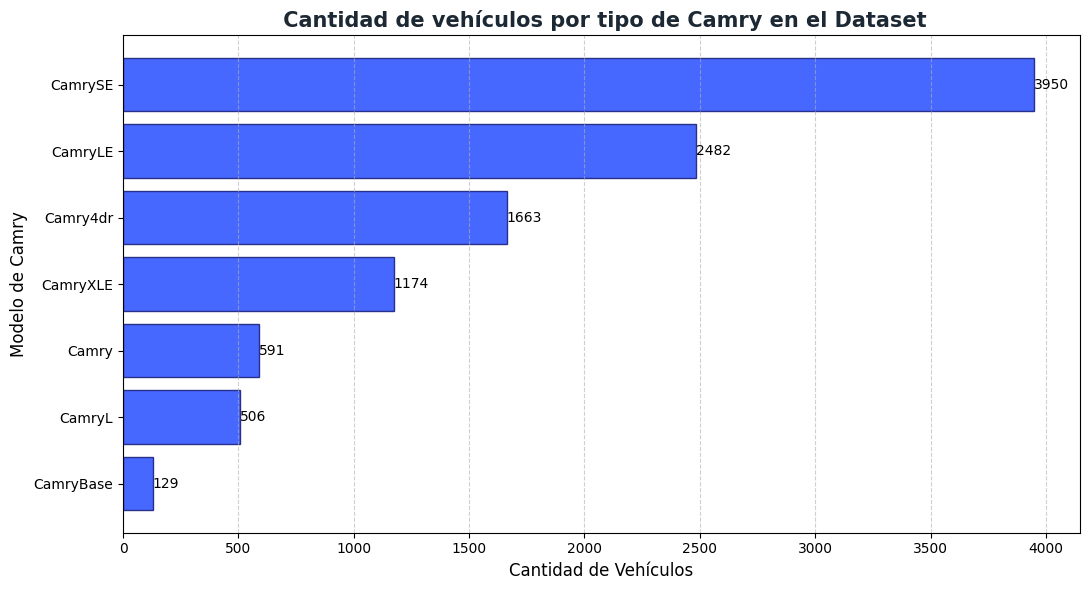

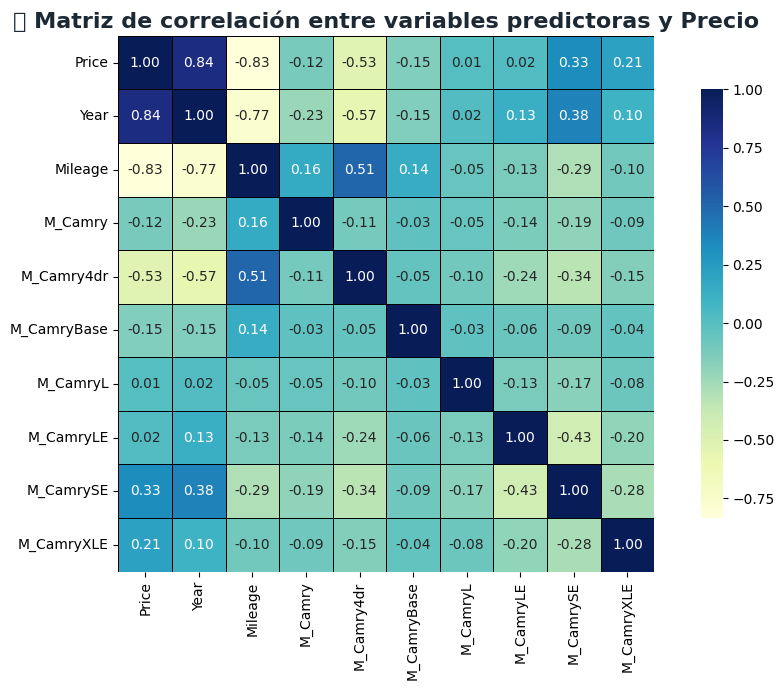

In [10]:
# Importación de librerías adicionales necesarias (si no estaban en el encabezado)
import seaborn as sns

print("---  Revisión inicial del dataset ---")
print("\n Valores nulos por columna:\n")
# Dado el preprocesamiento inicial, es probable que no haya nulos en el subset de 'Camry',
# pero la revisión es fundamental.
print(data.isna().sum()) 
print("\n Estadísticas descriptivas generales:\n")
print(data.describe())

# Nuevo esquema de colores (más vibrante)
colores_vibrantes = {
    "hist": "#FF5733",        # Rojo Naranja
    "box": "#33FF57",         # Verde Lima
    "hexbin": "viridis",      # Mapa de calor de viridis
    "barras": "#3357FF",      # Azul brillante
    "heatmap": "YlGnBu"       # Gradiente de amarillo, verde y azul
}

# --------------------------------------------------------------------------------------
##  Gráfico 1: Histograma de precios (Distribución)
plt.figure(figsize=(9, 5))
plt.hist(data["Price"], bins=40, color=colores_vibrantes["hist"], edgecolor="#A0331A", alpha=0.9)
plt.title(" Distribución de precios de vehículos (Toyota Camry)", fontsize=15, color="#1C2833", fontweight='bold')
plt.xlabel("Precio (USD)", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------------------------
##  Gráfico 2: Boxplot de precios por año (Relación Año-Precio)
plt.figure(figsize=(12, 6))
years = sorted(data["Year"].unique())
price_data = [data.loc[data["Year"] == y, "Price"] for y in years]
plt.boxplot(price_data, labels=years, patch_artist=True,
            boxprops=dict(facecolor=colores_vibrantes["box"], color="#1E8449", linewidth=1.5),
            medianprops=dict(color="#8B0000", linewidth=2))
plt.title(" Distribución del precio por año del vehículo", fontsize=15, color="#1C2833", fontweight='bold')
plt.xlabel("Año del vehículo", fontsize=12)
plt.ylabel("Precio (USD)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------------------------
##  Gráfico 3: Hexbin (Densidad Año vs Precio)
plt.figure(figsize=(10, 6))
hb = plt.hexbin(data["Year"], data["Price"], gridsize=30, cmap=colores_vibrantes["hexbin"], mincnt=1)
plt.colorbar(hb, label="Densidad de Observaciones (Vehículos)", orientation='vertical')
plt.title(" Densidad de precios por año del vehículo (Hexbin)", fontsize=15, color="#1C2833", fontweight='bold')
plt.xlabel("Año", fontsize=12)
plt.ylabel("Precio (USD)", fontsize=12)
plt.grid(True, linestyle=":", alpha=0.5)
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------------------------
##  Gráfico 4: Barras horizontales (Cantidad por modelo Camry)
model_columns = [c for c in data.columns if c.startswith("M_")]
model_counts = data[model_columns].sum().sort_values(ascending=False) # Ordenado de mayor a menor para mejor visualización
model_counts.index = model_counts.index.str.replace('M_', '') # Limpiar nombres de modelos

plt.figure(figsize=(11, 6))
bars = plt.barh(model_counts.index, model_counts.values, color=colores_vibrantes["barras"], edgecolor="#1A237E", alpha=0.9)
plt.title(" Cantidad de vehículos por tipo de Camry en el Dataset", fontsize=15, color="#1C2833", fontweight='bold')
plt.xlabel("Cantidad de Vehículos", fontsize=12)
plt.ylabel("Modelo de Camry", fontsize=12)

# Añadir etiquetas a las barras para mayor claridad
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{int(bar.get_width())}', 
             va='center', ha='left', fontsize=10)

plt.grid(axis='x', linestyle="--", alpha=0.6)
plt.gca().invert_yaxis() # Mover el modelo más popular a la parte superior
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------------------------
##  Gráfico 5: Matriz de correlación
plt.figure(figsize=(10, 7))
corr = data.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap=colores_vibrantes["heatmap"], fmt=".2f", 
            linewidths=0.7, linecolor='black', square=True, cbar_kws={'shrink': 0.8})
plt.title(" Matriz de correlación entre variables predictoras y Precio", fontsize=16, color="#1C2833", fontweight='bold')
plt.tight_layout()
plt.show()

### Punto 1 - Random forest con librería

En la celda 1, usando la librería sklearn entrenen un modelo de Randon Forest para regresion  y comenten sobre el desempeño del modelo.

In [9]:
# Celda 1
rf_base = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=0) 
rf_base.fit(X_train, y_train)

# Predicciones conjunto de prueba
predicciones = rf_base.predict(X_test)

# Evaluación desempeño
error_absoluto = mean_absolute_error(y_test, predicciones)
raiz_error_cuadratico = np.sqrt(mean_squared_error(y_test, predicciones))
coef_determinacion = r2_score(y_test, predicciones)

# 🧾 Resultados del modelo
print("==================================================================")
print("         Resultados del Modelo Random Forest Base           ")
print("==================================================================")
print(f" MAE  (Error Absoluto Medio):      $ {error_absoluto:,.2f}")
print(f" RMSE (Raíz del Error Cuadrático): $ {raiz_error_cuadratico:,.2f}")
print(f" R²   (Coeficiente de Determinación): {coef_determinacion:.4f}")
print("==================================================================")

          Resultados del Modelo Random Forest Base           
MAE  (Error Absoluto Medio):      $ 1,314.42
RMSE (Raíz del Error Cuadrático): $ 1,765.41
R²   (Coeficiente de Determinación): 0.7962


### Punto 2 - Calibración de parámetros Random forest

En la celda 2, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresion, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [13]:
# Celda 2
parametros = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],  
    "max_features": ["auto", "sqrt", "log2"] 
}

# Grid Search
modelo_rf = RandomForestRegressor(random_state=42)
busqueda = GridSearchCV(
    estimator=modelo_rf,
    param_grid=parametros,
    cv=5,                
    scoring="r2",         # Métrica de eva
    n_jobs=-1,            # Usa todos los núcleos dispo
    verbose=2             # Nivel de detalle en la salida
)

# Entrenamientobúsqueda
# Esto puede tomar unos minutos dependiendo del tamaño del dataset y el espacio de búsqueda.
busqueda.fit(X_train, y_train)

# Resultados
mejores_params = busqueda.best_params_
mejor_score = busqueda.best_score_

print("\n" + "="*70)
print("             🎉 Resultados de la Calibración con GridSearchCV 🎉")
print("="*70)
print("🔧 Mejores hiperparámetros encontrados (Maximizando R²):")
for clave, valor in mejores_params.items():
    print(f"   - {clave.ljust(15)}: {valor}")

print("\n Mejor puntuación promedio (R²) en Validación Cruzada: {:.4f}".format(mejor_score))
print("="*70)





Fitting 5 folds for each of 27 candidates, totalling 135 fits

             🎉 Resultados de la Calibración con GridSearchCV 🎉
🔧 Mejores hiperparámetros encontrados (Maximizando R²):
   - max_depth      : 10
   - max_features   : sqrt
   - n_estimators   : 200

📈 Mejor puntuación promedio (R²) en Validación Cruzada: 0.8460


In [21]:
modelo_final = busqueda.best_estimator_ 
modelo_final.fit(X_train, y_train)

# Predicciones sobre los datos
predicciones = modelo_final.predict(X_test)

# Cálculo de métricas
mae = mean_absolute_error(y_test, predicciones)
rmse = np.sqrt(mean_squared_error(y_test, predicciones))
r2 = r2_score(y_test, predicciones)

# resultados formateados
print("\n" + "="*55)
print("     Resultados del Modelo Random Forest Optimizado     ")
print("="*55)
print(f"R² (Coeficiente de Determinación): {r2:.4f}")
print(f"MAE  (Error Absoluto Medio):      $ {mae:,.2f}")
print(f"RMSE (Raíz del Error Cuadrático): $ {rmse:,.2f}")
print("="*55)


     Resultados del Modelo Random Forest Optimizado     
R² (Coeficiente de Determinación): 0.8400
MAE  (Error Absoluto Medio):      $ 1,147.20
RMSE (Raíz del Error Cuadrático): $ 1,564.25


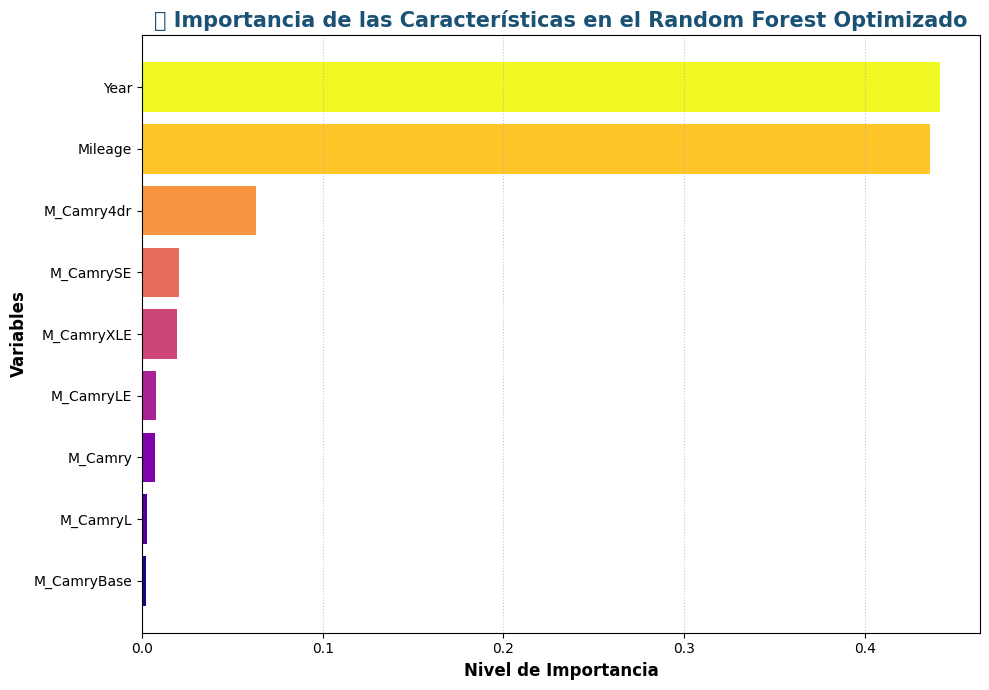


        Ranking de importancia de Variables
      Variable  Importancia
0         Year     0.441741
1      Mileage     0.436240
2   M_Camry4dr     0.062832
3    M_CamrySE     0.020267
4   M_CamryXLE     0.019286
5    M_CamryLE     0.007529
6      M_Camry     0.007160
7     M_CamryL     0.002928
8  M_CamryBase     0.002018


In [26]:
importancias = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': modelo_final.feature_importances_ 
}).sort_values(by='Importancia', ascending=True) 

# gráfico
plt.figure(figsize=(10, 7))
n_features = len(importancias)
colores_gradiente = plt.cm.plasma(np.linspace(0, 1, n_features)) 
barras = plt.barh(importancias['Variable'], importancias['Importancia'],
                  color=colores_gradiente)

# Etiquetas/estilo
plt.xlabel('Nivel de Importancia', fontsize=12, fontweight='semibold')
plt.ylabel('Variables', fontsize=12, fontweight='semibold')
plt.title(' Importancia de las Características en el Random Forest Optimizado', fontsize=15, fontweight='bold', color='#1A5276')
plt.grid(axis='x', linestyle=':', alpha=0.7)
plt.xticks(rotation=0) # etiquetas X estaran horizontales
plt.tight_layout()
plt.show()

# ranking en consola (Ordenado de MAYOR a MENOR)
ranking_final = importancias.sort_values(by='Importancia', ascending=False).reset_index(drop=True)

print("\n" + "="*55)
print("        Ranking de importancia de Variables")
print("="*55)
print(ranking_final)
print("="*55)


### Punto 3 - análisis de resultados, gracias y conclusiones
En la celda 3

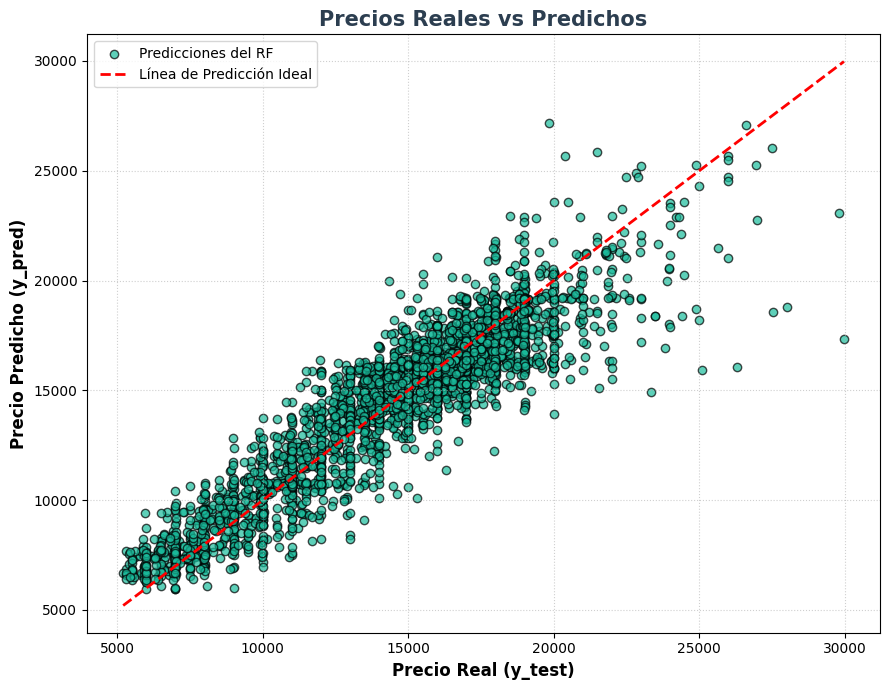

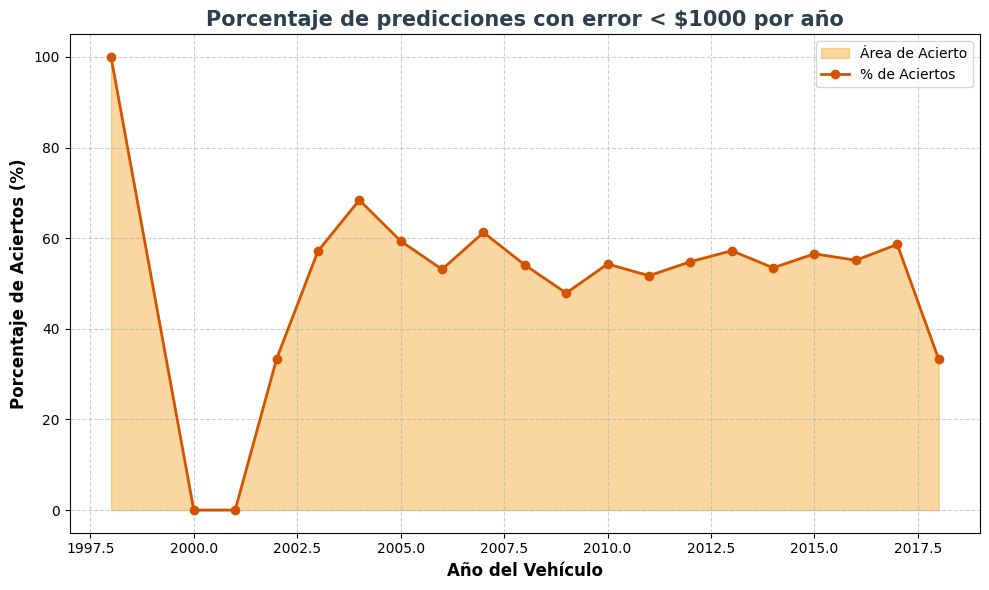

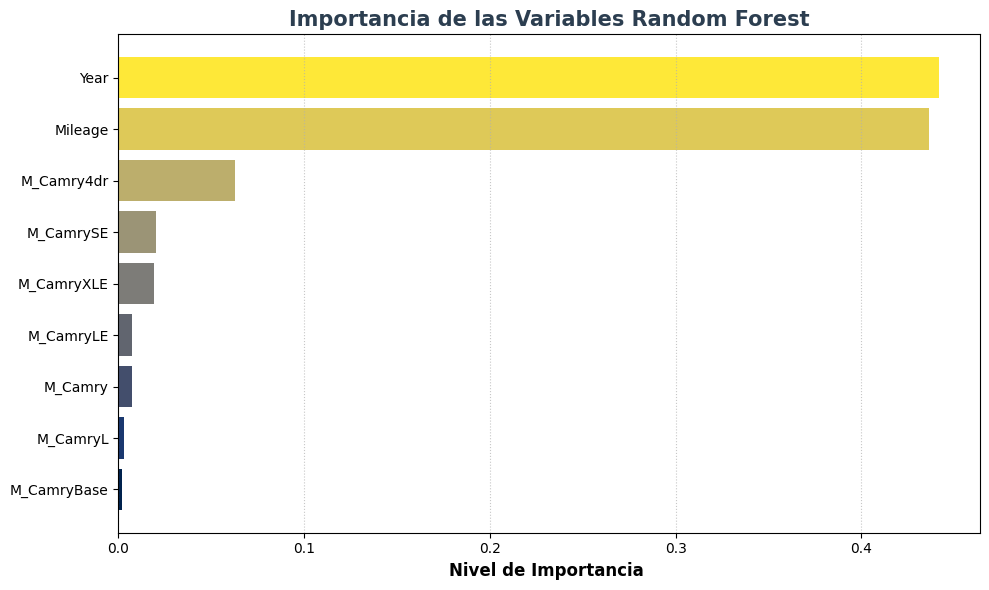


========== CONCLUSIONES ==========
• Desempeño General (R²): El modelo Random Forest ajustado obtuvo un R² de 0.8400, lo que significa que el 84.00% de la variabilidad en los precios es explicada por las variables.
• Precisión (MAE): El Error Absoluto Medio (MAE) de $1,147.20 indica que el error promedio de la predicción es de aproximadamente $1,147.
• Control de Errores (RMSE): El RMSE de $1,564.25 (ligeramente superior al MAE) confirma que, aunque hay algunos errores grandes, el modelo los controla de manera efectiva.
• Validación Visual: El gráfico de dispersión confirma una fuerte correlación lineal, pues los puntos se alinean bien cerca de la línea ideal (y=x).
• Factores Clave: Las variables más influyentes fueron: **Year, Mileage, M_Camry4dr.
• Utilidad: El modelo es robusto y ofrece un alto grado de precisión, haciéndolo ideal para la estimación automática de precios de Toyota Camry en un entorno real.


In [30]:
#celda 3
# precios reales vs predichoss
plt.figure(figsize=(9, 7))
#yo use predicciones
plt.scatter(y_test, predicciones, alpha=0.7, color='#1ABC9C', edgecolor='k', label='Predicciones del RF') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Línea de Predicción Ideal')
plt.xlabel('Precio Real (y_test)', fontsize=12, fontweight='semibold')
plt.ylabel('Precio Predicho (y_pred)', fontsize=12, fontweight='semibold')
plt.title('Precios Reales vs Predichos', fontsize=15, fontweight='bold', color='#2C3E50')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# Porcentaje de aciertos por año 
errores_final = np.abs(y_test - predicciones) 
aciertos = (errores_final < 1000).astype(int) 

# Calcular porcentaje de aciertos por año
porcentaje_por_año = (
    pd.DataFrame({'Año': X_test['Year'], 'Acierto': aciertos})
    .groupby('Año')
    .mean() * 100
)

# Gráfico de porcentaje de aciertos
plt.figure(figsize=(10, 6))
plt.fill_between(porcentaje_por_año.index, porcentaje_por_año['Acierto'],
                 color='#F39C12', alpha=0.4, label='Área de Acierto')
plt.plot(porcentaje_por_año.index, porcentaje_por_año['Acierto'],
         color='#D35400', marker='o', lw=2, linestyle='-', label='% de Aciertos') 
plt.title('Porcentaje de predicciones con error < $1000 por año', fontsize=15, fontweight='bold', color='#2C3E50')
plt.xlabel('Año del Vehículo', fontsize=12, fontweight='semibold')
plt.ylabel('Porcentaje de Aciertos (%)', fontsize=12, fontweight='semibold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 🌲 3️⃣ Importancia de las variables 
importances = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': modelo_final.feature_importances_ 
}).sort_values(by='Importancia', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importances['Variable'], importances['Importancia'],
          color=plt.cm.cividis(np.linspace(0, 1, len(importances)))) 
plt.xlabel('Nivel de Importancia ', fontsize=12, fontweight='semibold')
plt.title('Importancia de las Variables Random Forest', fontsize=15, fontweight='bold', color='#2C3E50')
plt.grid(axis='x', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

#  Conclusiones generales
print("\n" + "="*10 + " CONCLUSIONES " + "="*10)
print(f"• Desempeño General (R²): El modelo Random Forest ajustado obtuvo un R² de {r2:.4f}, lo que significa que el {r2*100:.2f}% de la variabilidad en los precios es explicada por las variables.")
print(f"• Precisión (MAE): El Error Absoluto Medio (MAE) de ${mae:,.2f} indica que el error promedio de la predicción es de aproximadamente ${mae:,.0f}.")
print(f"• Control de Errores (RMSE): El RMSE de ${rmse:,.2f} (ligeramente superior al MAE) confirma que, aunque hay algunos errores grandes, el modelo los controla de manera efectiva.")
print("• Validación Visual: El gráfico de dispersión confirma una fuerte correlación lineal, pues los puntos se alinean bien cerca de la línea ideal (y=x).")
# Extraer las variables más importantes para la conclusión
top_3_vars = importances.sort_values(by='Importancia', ascending=False).head(3)['Variable'].tolist()
print(f"• Factores Clave: Las variables más influyentes fueron: **{', '.join(top_3_vars)}.")
print("• Utilidad: El modelo es robusto y ofrece un alto grado de precisión, haciéndolo ideal para la estimación automática de precios de Toyota Camry en un entorno real.")
print("="*28)

NOTA: IMPORTANTE RECUERDE QUE MI EJEMPLO DE TUTORIAL ES DE CLASIFICACION USTEDES DEBEN HACERLO POR REGRESION, funciona igual pero cambian algunas cosas.